# Compare RFE and SelectKbest

In [4]:
%matplotlib inline
%run talibref.py
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

ticker = 'IYZ'
startdate=datetime.date(2010, 1, 1)
enddate = datetime.date(2015, 12, 1)
df = generate_ticker_data(ticker, startdate, enddate)
dftouse=df.copy()

IGNORE = ['date', 'result_1','close_1','perf_1','result_14','close_14','perf_14','results']
INDICATORS=[]
for v in df.columns:
    l=df[v].unique()
    if len(l) <= 10 and v not in IGNORE:
        #print v, l
        INDICATORS.append(v)
        
STANDARDIZABLE = []
for v in df.columns:
    if v not in INDICATORS and v not in IGNORE:
        #print v
        STANDARDIZABLE.append(v)

dftouse['date'] = pd.to_datetime(dftouse['date'])
mask = (dftouse.date < '2015-01-01').values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(dftouse[mask][STANDARDIZABLE])
dftouse[STANDARDIZABLE] = scaler.transform(dftouse[STANDARDIZABLE])

lcols=[]
for c in list(dftouse.columns):
    if c not in IGNORE: 
        lcols.append(c)
        
def cv_optimize(clf, parameters, X, y, n_folds, score_func):
    fitmodel = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    fitmodel.fit(X, y)
    return fitmodel.best_estimator_

from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    return clf, Xtrain, ytrain, Xtest, ytest

X=dftouse[lcols].values
y=dftouse['results'].values
Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]  
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

We create a list `lcols` of the columns we will use in our classifier. This list should not contain the response `RESP`. How many features do we have?

### How many features should we select? try selectKbest

In [18]:
%%time
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression

def evaluate(clf):
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    df_pred = df[~mask].reset_index(drop=True)
    df_pred['pred_result'] = clf.predict(Xtest)
    df_pred['result_baseline'] = np.ones(df_pred.shape[0])
    
    _,_,ROI_base,_,_ = evaluate_profit(df_pred,startdate, enddate, 10000, 'result_baseline', 'close', False, [1])
    _,_,ROI_long,_,_ = evaluate_profit(df_pred, startdate, enddate,10000, 'pred_result', 'close', False,[1])
    _,_,ROI_lgst,_,_ = evaluate_profit(df_pred,startdate, enddate, 10000, 'pred_result', 'close', False,[1,0])
    return training_accuracy, test_accuracy, ROI_base, ROI_long, ROI_lgst

k_result = {}
k_features = {}
for k in range(1, len(lcols)+1):
    selectk = SelectKBest(k=k, score_func=f_regression)
    selectk.fit(reuse_split['Xtrain'], reuse_split['ytrain'])
    pipeLR = Pipeline([('selectk', selectk), ('LR', LogisticRegression(penalty="l1"))])
    pipeLR,_,_,_,_ = do_classify(pipeLR, {"LR__C": [0.01, 0.05, 0.08, 0.1, 0.2]}, 
                                 dftouse, lcols, u'results', 1, reuse_split=reuse_split)
    k_result[k] = np.array(evaluate(pipeLR))
    k_features[k] = np.array(lcols)[selectk.get_support()]

Wall time: 30.4 s


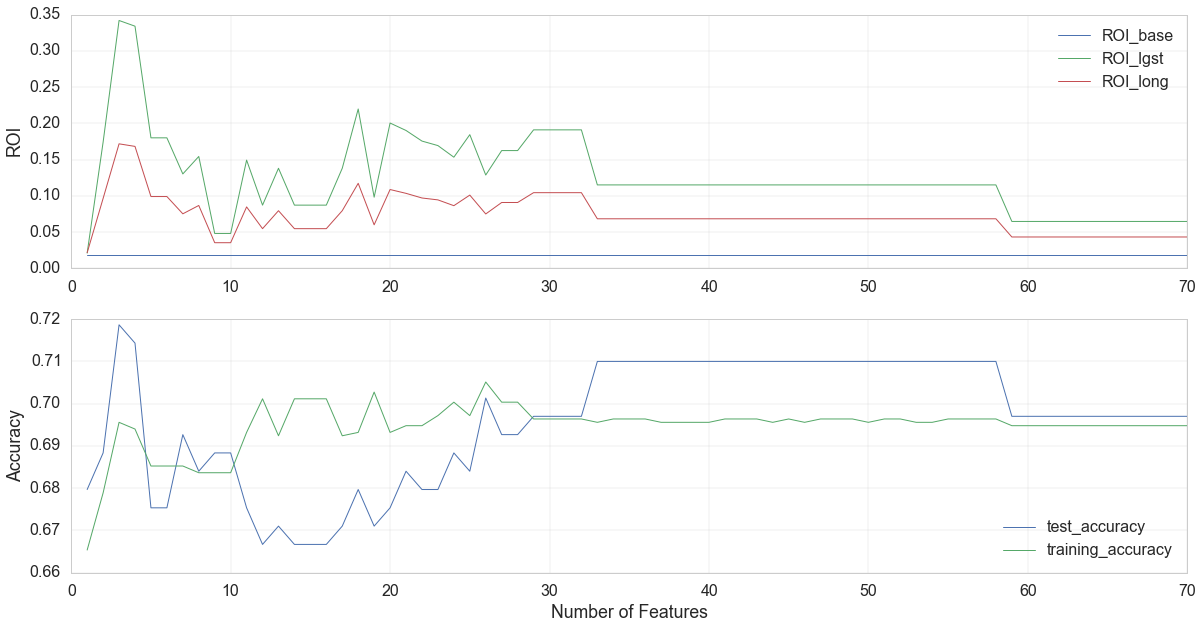

In [19]:
def plot_features_vs_ROI(result):
    number_of_features = result.keys()
    unzipped = zip(*result.values())
    training_accuracy = unzipped[0]
    test_accuracy = unzipped[1]
    ROI_base = unzipped[2]
    ROI_long = unzipped[3]
    ROI_lgst = unzipped[4]

    fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
    ax0.plot(number_of_features, ROI_base, label="ROI_base", lw=1)
    ax0.plot(number_of_features, ROI_lgst, label="ROI_lgst", lw=1)
    ax0.plot(number_of_features, ROI_long, label="ROI_long", lw=1)
    ax0.set_ylabel("ROI")
    ax0.legend(loc='upper right')
    ax0.grid(linewidth=0.3)
    ax1.plot(number_of_features, test_accuracy, label="test_accuracy", lw=1)
    ax1.plot(number_of_features, training_accuracy, label="training_accuracy", lw=1)
    ax1.legend(frameon=False, loc='lower right')
    ax1.grid(linewidth=0.3)
    ax1.set_ylabel("Accuracy")
    ax1.set_xlabel("Number of Features")

plot_features_vs_ROI(k_result)

Best result with 3 features, notice a sharp drop at 7 features. I think the result is pretty random due to collinearity introduced by additional features, what features are selected? 

In [20]:
selectk = SelectKBest(score_func=f_regression)
pipeLR = Pipeline([('selectk', selectk), ('LR', LogisticRegression(penalty="l1"))])
pipeLR,_,_,_,_ = do_classify(pipeLR, {"selectk__k":range(1,30), "LR__C": [0.01, 0.05, 0.08, 0.1, 0.2]}, 
                             dftouse, lcols, u'results', 1, reuse_split=reuse_split)

print "LR__C: {0}".format(pipeLR.get_params()['LR__C']) 
print "selectk__k: {0}".format(pipeLR.get_params()['selectk__k'])
print np.array(lcols)[pipeLR.named_steps['selectk'].get_support()].tolist()
print evaluate(pipeLR)

LR__C: 0.05
selectk__k: 28
['bb_pct', 'ema_signal1', 'kama_signal1', 'sar_signal', 'plus_di', 'minus_di', 'adx_direction', 'aroon_osc', 'aroon_signal', 'cci', 'macd', 'macd_hist', 'macd_signal', 'ppo', 'mfi', 'roc', 'rsi', 'ult_osc', 'willr', 'wr_signal', 'ad_osc', 'ad_signal', 'stoch_slowk', 'stoch_slowd', 'sslow_signal', 'stoch_fastk', 'stoch_fastd', 'srsi_signal']
(0.70031796502384736, 0.69264069264069261, 0.018359965999999985, 0.090719921399999653, 0.16236286049999871)


28 features selcted by SelectKBest gave accuracy of 0.699 and ROI to 17.9%. I am not sure why it did not select just 3 features, which should gave higher score according to plot earlier! one possible explantion is pipeline select the features in cross validation fold, so score is within each fold, while diagram above use score generated from entire training set.


### How many features should we select? try recursive feature elimination (RFE)

In [278]:
%%time
# Recursive Feature Elimination, VERY SLOW!!!
from sklearn.feature_selection import RFE
k_result = {}
k_features = {}
for k in range(1, 16):    
    model = LogisticRegression(penalty="l1")
    rfe = RFE(model, k)
    rfe = rfe.fit(reuse_split['Xtrain'], reuse_split['ytrain'])
    pipeLR = Pipeline([('rfe', rfe), ('LR', model)])
    pipeLR,_,_,_,_ = do_classify(pipeLR, {"LR__C": [0.005, 0.01, 0.02, 0.05, 10.0]}, 
                                 dftouse, lcols, u'results', 1, reuse_split=reuse_split)
    k_result[k] = np.array(evaluate(pipeLR))
    k_features[k] = np.array(lcols)[rfe.support_]

Wall time: 1h 13min 18s


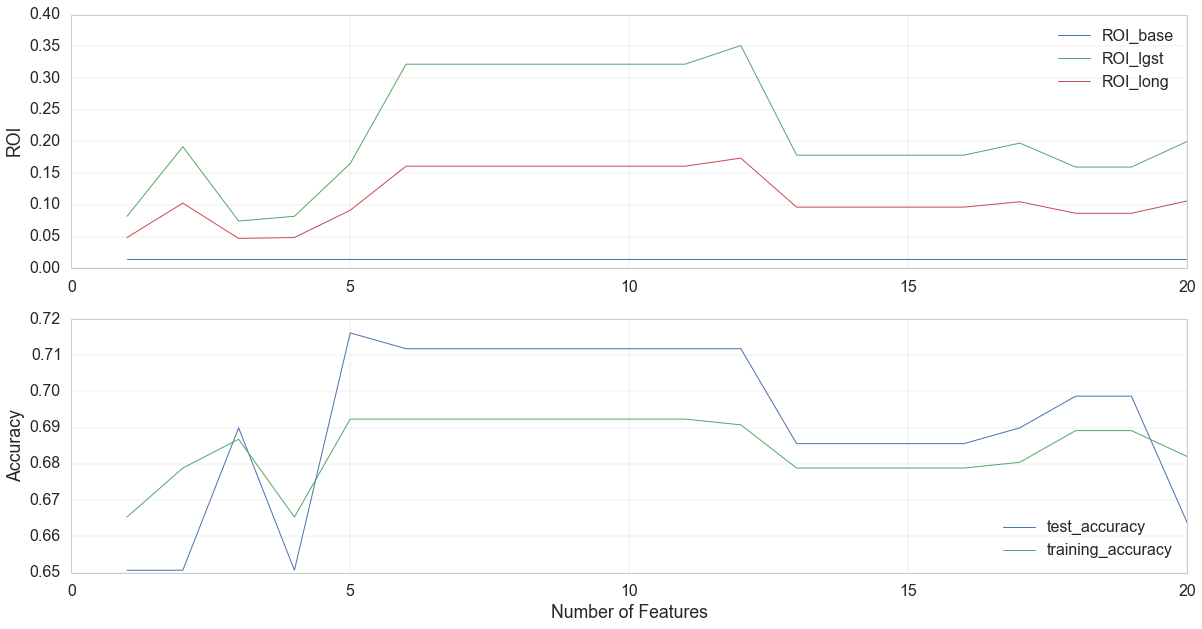

In [279]:
plot_features_vs_ROI(k_result)

#### more consistent result, good ROI and accuracy using 6-12 features selected by RFE, we'll also do this within pipeline

In [351]:
rfe = RFE(LogisticRegression(penalty="l1"))
pipeLR = Pipeline([('rfe', rfe), ('LR', LogisticRegression(penalty="l1"))])
pipeLR,_,_,_,_ = do_classify(pipeLR, {"rfe__n_features_to_select":range(4,12), "LR__C": [0.01, 0.05, 0.08, 0.1, 0.2]}, 
                             dftouse, lcols, u'results', 1, reuse_split=reuse_split)

In [352]:
print "LR__C: {0}".format(pipeLR.get_params()['LR__C']) 
print "rfe__n_features_to_select: {0}".format(pipeLR.get_params()['rfe__n_features_to_select'])
print  np.array(lcols)[pipeLR.named_steps['rfe'].support_].tolist()

LR__C: 0.05
rfe__n_features_to_select: 11
['bb_signalup', 'bb_signaldn', 'bb_signal', 'adx_signal', 'mfi_signal', 'roc_signal', 'rsi', 'rsi_signal', 'wr_signal', 'stoch_slowk', 'cv_signal']


In [357]:
evaluate(pipeLR)

(0.69236883942766292,
 0.71179039301310043,
 0.014620033999999942,
 0.16093366990000013,
 0.32177924460000085)

only 11 features selcted by RFE boosted accuracy to 71.2 and ROI to 32%, looks promising